# Aplicando Optimizador ADAM, regularizacion L2, DropOut y Normalizacion HE Normal

## Librerias

In [2]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras
print("Tensorflow version:",tf.__version__)
print("Keras version:",keras.__version__)

#Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time


# Callbacks
from my_callbacks import TqdmProgressCallback, StopWhenValLossBelow, StopTrainingAtEpoch
from keras.callbacks import EarlyStopping

Tensorflow version: 2.20.0
Keras version: 3.13.2


## Cargamos los datos

In [3]:
ATT_FILE = "FootballPlayerPreparedCleanAttributes.csv"
LABEL_FILE = "FootballPlayerOneHotEncodedClasses.csv"

TRAIN_RATE=0.8

attributes = pd.read_csv(ATT_FILE)
label = pd.read_csv(LABEL_FILE)

n_instances = attributes.shape[0]
n_train = int(n_instances*TRAIN_RATE)
n_dev = int((n_instances-n_train)/2)

x_train = attributes.values[:n_train]
t_train = label.values[:n_train]

x_dev = attributes.values[n_train:n_train+n_dev]
t_dev = label.values[n_train:n_train+n_dev]

print ("x_train:",x_train.shape)
print ("t_train:",t_train.shape)

print ("x_dev:",x_dev.shape)
print ("t_dev:",t_dev.shape)

x_train: (12907, 22)
t_train: (12907, 4)
x_dev: (1613, 22)
t_dev: (1613, 4)


## Inicializamos las variables

In [5]:
INPUTS = x_train.shape[1]
OUTPUTS = t_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(x_train.shape[0]/1))
NUM_DEV_EXAMPLES = int (round (x_dev.shape[0]/1))
print("Input shape:", INPUTS)
print("Output shape:", OUTPUTS)
print("Training examples:", NUM_TRAINING_EXAMPLES)
print("Development examples:", NUM_DEV_EXAMPLES)

Input shape: 22
Output shape: 4
Training examples: 12907
Development examples: 1613


## Hyperparametros

In [6]:
ACTIVATION_FUNCTION = 'elu'
EPOCHS = 1000
LEARNING_RATE = 0.001
BATCH_SIZE = 512
LAYER_NEURONS = [64, 32, 16, 8]
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
DROPOUT_RATE = 0.2  # Tasa de dropout 20% de las neuronas se apagarán durante el entrenamiento
REGULARIZATION_FACTOR = 0.0001  
REGULARIZER = tf.keras.regularizers.L2(REGULARIZATION_FACTOR) # 
INITIALIZER = tf.keras.initializers.HeNormal() # Inicializador He Normal para capas con activación ELU

## Modelo

In [8]:
# --- Arquitectura ---
model = tf.keras.Sequential(name='DeepFeedForward_Optimizado')

# Capa de entrada 
model.add(tf.keras.layers.InputLayer(shape=(INPUTS,)))

for neurons in LAYER_NEURONS:
    # Capa Densa con L2 y He Normal
    model.add(tf.keras.layers.Dense(
        units=neurons, 
        activation=ACTIVATION_FUNCTION,
        kernel_regularizer=REGULARIZER,
        kernel_initializer=INITIALIZER 
    ))
    
    # Batch Normalization
    model.add(tf.keras.layers.BatchNormalization())
    
    # Dropout
    model.add(tf.keras.layers.Dropout(rate=DROPOUT_RATE))

# Capa de salida (Para Softmax se suele dejar el inicializador por defecto: Glorot Uniform)
model.add(tf.keras.layers.Dense(OUTPUTS, activation="softmax"))

## Compilacion

In [9]:
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=OPTIMIZER,
    metrics=["categorical_accuracy"]
)

## Entrenamiento

In [10]:
# --- Configuración de Callbacks ---
patienceStop_callback = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True # Recupera los pesos óptimos antes de que el modelo empeorara
)

stopWhenValLossBelow_callback = StopWhenValLossBelow(threshold=0.65)
stopTrainingAtEpoch_callback = StopTrainingAtEpoch(stop_epoch=5)

# Pasamos la variable EPOCHS en mayúsculas
tqdm_callback = TqdmProgressCallback(epochs=EPOCHS)

# Agrupamos los callbacks en una lista
callbacks_list = [
    tqdm_callback,           # Para ver la barra bonita
    patienceStop_callback    # Para detenerse de forma inteligente cuando deje de mejorar
]

# --- Ejecución del Entrenamiento ---
start = time.perf_counter()

history = model.fit(
    x=x_train, 
    y=t_train, 
    batch_size=BATCH_SIZE, # Variable en mayúsculas
    epochs=EPOCHS,         # Variable en mayúsculas
    verbose=0,             # Silenciado para que TQDM funcione limpiamente
    validation_data=(x_dev, t_dev),
    callbacks=callbacks_list 
)

print(f"\nTiempo total de entrenamiento: {time.perf_counter() - start:.2f} segundos")

Epochs:  23%|██▎       | 233/1000 [00:18<01:00, 12.58it/s]


Tiempo total de entrenamiento: 18.60 segundos


## Resultados

In [12]:
# Extraer el historial
results = pd.DataFrame(history.history)

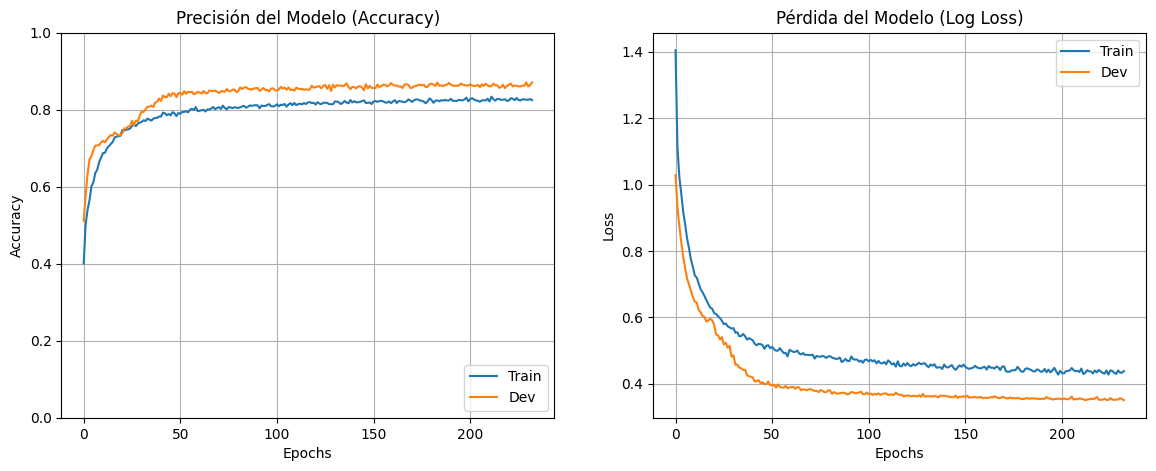

In [14]:
# Dos subgráficos para precision y loss 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica 1: Precisión (Accuracy)
ax1.plot(results[['categorical_accuracy', 'val_categorical_accuracy']])
ax1.set_title('Precisión del Modelo (Accuracy)')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(['Train', 'Dev'], loc='lower right')
ax1.grid(True)
ax1.set_ylim(0, 1) # Aquí sí tiene sentido limitar entre 0 y 1

# Gráfica 2: Pérdida (Loss)
ax2.plot(results[['loss', 'val_loss']])
ax2.set_title('Pérdida del Modelo (Log Loss)')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(['Train', 'Dev'], loc='upper right')
ax2.grid(True)


plt.show()

In [15]:
print("--- Métricas de la Mejor Época ---")
print(f"Accuracy (Train): {results['categorical_accuracy'].iloc[-1]:.4f}")
print(f"Accuracy (Dev): {results['val_categorical_accuracy'].iloc[-1]:.4f}")
print(f"Loss (Train): {results['loss'].iloc[-1]:.4f}")
print(f"Loss (Dev): {results['val_loss'].iloc[-1]:.4f}")

--- Métricas de la Mejor Época ---
Accuracy (Train): 0.8249
Accuracy (Dev): 0.8710
Loss (Train): 0.4380
Loss (Dev): 0.3501


## Prediccion y Evaluacion

In [16]:
# Obtener predicciones crudas (probabilidades)
dev_predictions = model.predict(x_dev)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [17]:
# Convertir probabilidades directamente a la clase predicha (índice 0, 1, o 2)
y_pred_classes = np.argmax(dev_predictions, axis=1)

In [18]:
# Convertir el target real a formato de clase (deshacer el one-hot encoding)
y_true_classes = np.argmax(t_dev, axis=1)

In [19]:
# Ver predicciones correctas totales (Reemplaza al Counter)
correct_predictions = np.equal(y_pred_classes, y_true_classes)
total_correct = np.sum(correct_predictions)
total_samples = len(y_true_classes)

print(f"\nPredicciones exactas: {total_correct} de {total_samples} ({(total_correct/total_samples)*100:.2f}%)")


Predicciones exactas: 1399 de 1613 (86.73%)


In [20]:
# Reporte detallado (Precisión, Recall, F1-Score por clase)
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_true_classes, y_pred_classes))


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       418
           1       0.79      0.80      0.80       402
           2       0.83      0.86      0.84       421
           3       0.95      0.92      0.93       372

    accuracy                           0.87      1613
   macro avg       0.87      0.87      0.87      1613
weighted avg       0.87      0.87      0.87      1613



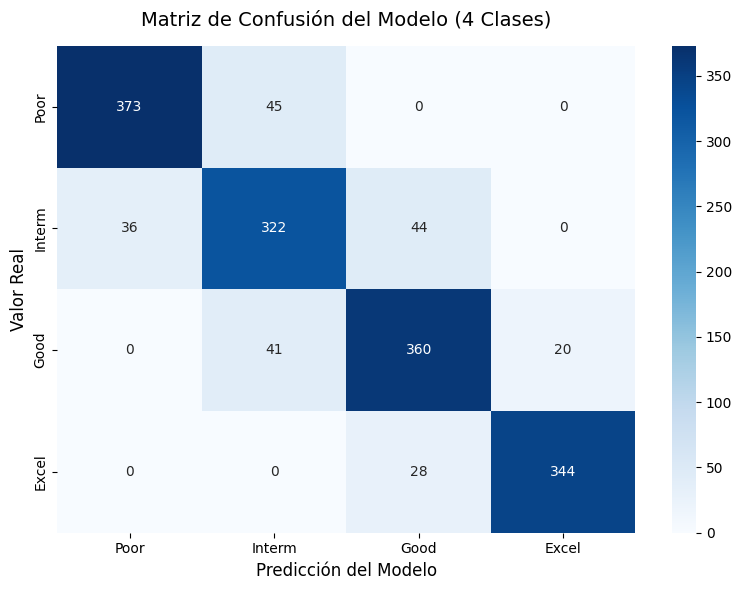

In [21]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))

nombres_clases = ['Poor', 'Interm', 'Good', 'Excel']

# 4. Crear el mapa de calor
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=nombres_clases, 
    yticklabels=nombres_clases
)

plt.title('Matriz de Confusión del Modelo (4 Clases)', fontsize=14, pad=15)
plt.xlabel('Predicción del Modelo', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)

plt.tight_layout()
plt.show()